In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from datetime import datetime

data = pd.read_excel("Online_Retail.xlsx")

data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
data = data.dropna(subset=["CustomerID"])

data = data[~data["InvoiceNo"].astype(str).str.startswith('C')]

data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
ref_date = data["InvoiceDate"].max()

rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalPrice": "sum"
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


In [5]:
from sklearn.preprocessing import StandardScaler

rfm_scaled = rfm[["Recency", "Frequency", "Monetary"]]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scaled)


In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

cluster_summary = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(1)
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,19.9,135.5,2648.9
1,96.8,37.9,777.7
2,3.7,2566.0,126118.3
3,271.2,25.1,604.8


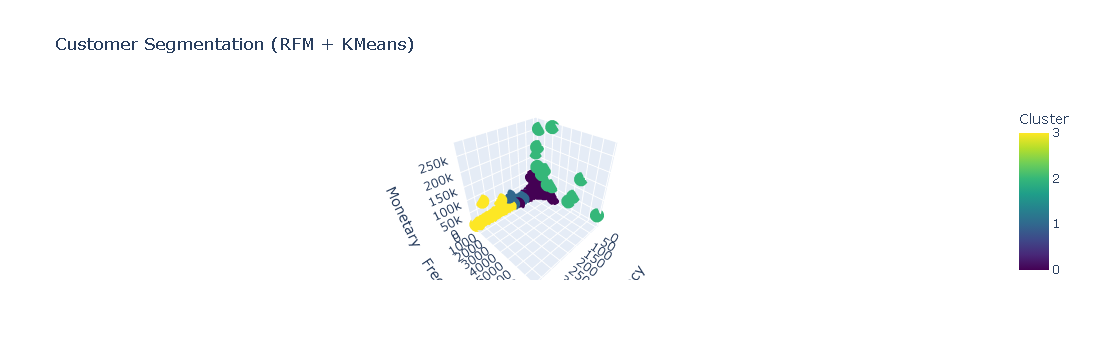

In [7]:
fig = px.scatter_3d(
    rfm, x='Recency', y='Frequency', z='Monetary',
    color='Cluster', title='Customer Segmentation (RFM + KMeans)',
    color_continuous_scale='Viridis'
)
fig.show()


In [8]:
persona_labels = {
    0: "Loyal Champions",
    1: "Recent High Spenders",
    2: "At-Risk Customers",
    3: "Occasional Buyers"
}

rfm["Persona"] = rfm["Cluster"].map(persona_labels)

persona_summary = rfm.groupby("Persona")[["Recency", "Frequency", "Monetary"]].mean().round(1)
persona_summary


,Recency,Frequency,Monetary
Persona,,,
At-Risk Customers,3.7,2566.0,126118.3
Loyal Champions,19.9,135.5,2648.9
Occasional Buyers,271.2,25.1,604.8
Recent High Spenders,96.8,37.9,777.7


In [9]:
rfm.to_excel("Customer_Segmentation_Output.xlsx", index=False)
print("✅ Results saved to 'Customer_Segmentation_Output.xlsx'")


✅ Results saved to 'Customer_Segmentation_Output.xlsx'


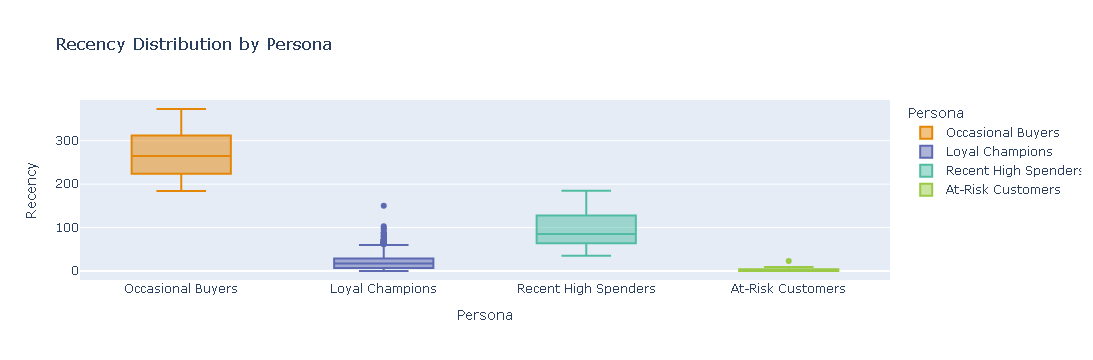

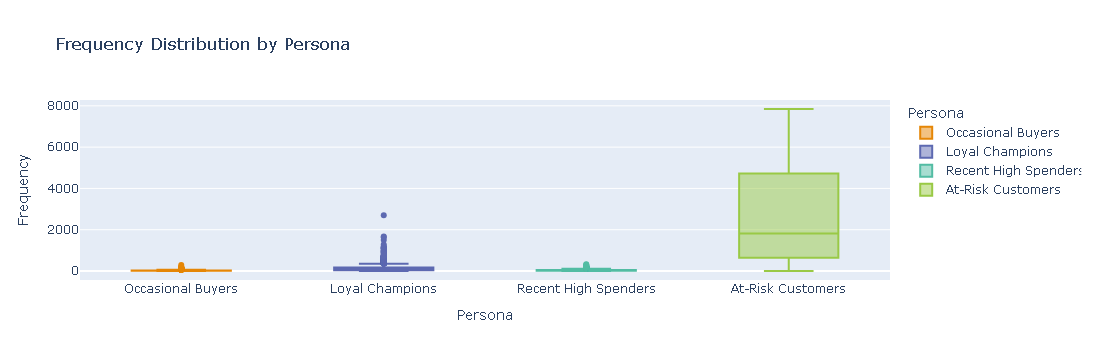

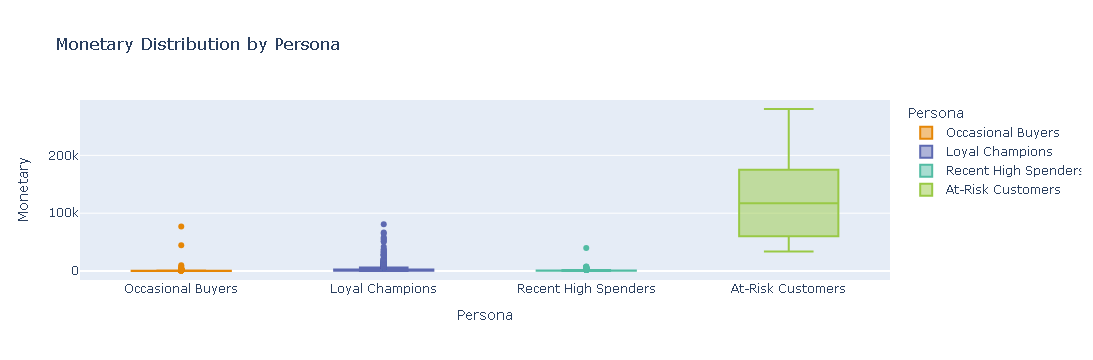

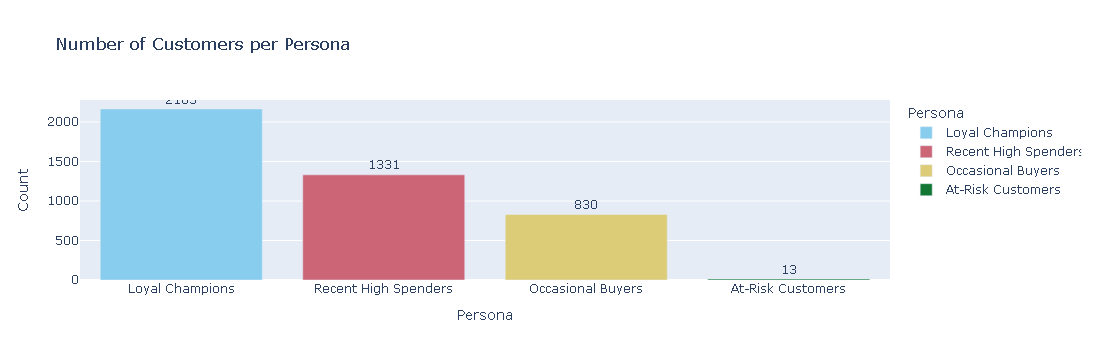

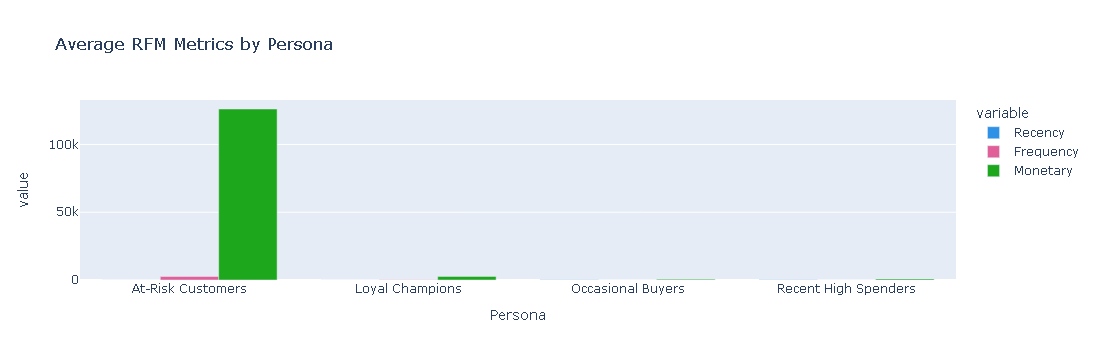

In [10]:
import plotly.express as px


fig_r = px.box(
    rfm, x="Persona", y="Recency", color="Persona",
    title="Recency Distribution by Persona", color_discrete_sequence=px.colors.qualitative.Vivid
)
fig_r.show()

fig_f = px.box(
    rfm, x="Persona", y="Frequency", color="Persona",
    title="Frequency Distribution by Persona", color_discrete_sequence=px.colors.qualitative.Vivid
)
fig_f.show()

fig_m = px.box(
    rfm, x="Persona", y="Monetary", color="Persona",
    title="Monetary Distribution by Persona", color_discrete_sequence=px.colors.qualitative.Vivid
)
fig_m.show()

persona_count = rfm["Persona"].value_counts().reset_index()
persona_count.columns = ["Persona", "Count"]

fig_size = px.bar(
    persona_count, x="Persona", y="Count", color="Persona",
    text="Count", title="Number of Customers per Persona",
    color_discrete_sequence=px.colors.qualitative.Safe
)
fig_size.update_traces(textposition="outside")
fig_size.show()

persona_summary_reset = rfm.groupby("Persona")[["Recency", "Frequency", "Monetary"]].mean().reset_index()
fig_summary = px.bar(
    persona_summary_reset.melt(id_vars="Persona"),
    x="Persona", y="value", color="variable",
    barmode="group", title="Average RFM Metrics by Persona",
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig_summary.show()


In [12]:
fig_summary.write_html("Persona_RFM_Summary.html")
fig_size.write_html("Persona_Size_Distribution.html")
fig_r.write_html("Recency_BoxPlot.html")


In [13]:

persona_summary = rfm.groupby("Persona")[["Recency", "Frequency", "Monetary"]].mean().round(2)
persona_summary["Customer Count"] = rfm["Persona"].value_counts()

print("===== CUSTOMER SEGMENTATION INSIGHT SUMMARY =====\n")

for persona, row in persona_summary.iterrows():
    print(f"Persona: {persona}")
    print(f" - Avg Recency (days since last purchase): {row['Recency']}")
    print(f" - Avg Frequency (transactions): {row['Frequency']}")
    print(f" - Avg Monetary Value (£): {row['Monetary']}")
    print(f" - Customer Count: {int(row['Customer Count'])}\n")

print("=== STRATEGIC INSIGHTS ===\n")
print("1. Loyal Champions → Frequent and high-spending customers. Retain them with early access or loyalty rewards.")
print("2. Recent High Spenders → New, valuable customers. Encourage repeat purchases via personalized offers.")
print("3. At-Risk Customers → Haven’t purchased in a while. Win them back with reactivation campaigns.")
print("4. Occasional Buyers → Moderate engagement. Recommend similar products or targeted promotions.\n")

print("💡 Recommendation:")
print("Focus retention campaigns on At-Risk customers and conversion campaigns on Recent High Spenders.")
print("Maintain satisfaction of Loyal Champions with VIP benefits and early product previews.")


===== CUSTOMER SEGMENTATION INSIGHT SUMMARY =====

Persona: At-Risk Customers
 - Avg Recency (days since last purchase): 3.69
 - Avg Frequency (transactions): 2566.0
 - Avg Monetary Value (£): 126118.31
 - Customer Count: 13

Persona: Loyal Champions
 - Avg Recency (days since last purchase): 19.89
 - Avg Frequency (transactions): 135.48
 - Avg Monetary Value (£): 2648.88
 - Customer Count: 2165

Persona: Occasional Buyers
 - Avg Recency (days since last purchase): 271.2
 - Avg Frequency (transactions): 25.09
 - Avg Monetary Value (£): 604.75
 - Customer Count: 830

Persona: Recent High Spenders
 - Avg Recency (days since last purchase): 96.85
 - Avg Frequency (transactions): 37.89
 - Avg Monetary Value (£): 777.69
 - Customer Count: 1331

=== STRATEGIC INSIGHTS ===

1. Loyal Champions → Frequent and high-spending customers. Retain them with early access or loyalty rewards.
2. Recent High Spenders → New, valuable customers. Encourage repeat purchases via personalized offers.
3. At-Risk

In [14]:
rfm.to_excel("Customer_Segmentation_Output.xlsx", index=False)
print("✅ Results saved to 'Customer_Segmentation_Output.xlsx'")


✅ Results saved to 'Customer_Segmentation_Output.xlsx'
